# R Aquilae
---

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import torch.nn          as nn
import torch

from torch.optim          import Adam
from tqdm                 import tqdm
from astropy              import units, constants
from ipywidgets           import interact

from p3droslo.utils       import convert_angular_to_spatial
from p3droslo.plot        import plot_cube_2D, plot_spectrum
from p3droslo.object      import AstroObject
from p3droslo.observation import DataCube

from p3droslo.model       import TensorModel, SphericallySymmetric
from p3droslo.utils       import print_var, interpolate, convert_angular_to_spatial
from p3droslo.lines       import Line
from p3droslo.loss        import Loss, fourier_loss_1D, fourier_loss_1D

In [2]:
obj = AstroObject('R Aql')

Using the parallax distance.


In [3]:
file = '/STER/hydroModels/jolienm/RAqlObservations/RAql-observations/ALMA_analysis/data/R_Aql/R_Aql_combined111_line_t0.15_spw2_CO.fits'
dat  = DataCube(file)

In [4]:
dat.img     = np.nan_to_num(dat.img, nan=0.0)
dat.img_min = dat.img.min()
dat.img_max = dat.img.max()

In [5]:
dat.plot_channel_maps()

interactive(children=(IntSlider(value=19, description='f', max=39), Output()), _dom_classes=('widget-interact'…

<function p3droslo.observation.DataCube.plot_channel_maps.<locals>.plot(f)>

In [6]:
dat.plot_spectrum()

interactive(children=(IntSlider(value=4095, description='i', max=8191), IntSlider(value=4095, description='j',…

<function p3droslo.observation.DataCube.plot_spectrum.<locals>.plot(i, j)>

In [7]:
fi_min, fi_max =    6,   35
xi_min, xi_max = 2500, 5700
yi_min, yi_max = 2500, 5700

obs       = dat.img[fi_min:fi_max, xi_min:xi_max, yi_min:yi_max].astype(np.float64)
obs_freqs = dat.fs [fi_min:fi_max]
obs_xlims = dat.xs [xi_max] - dat.xs[xi_min]
obs_ylims = dat.xs [xi_max] - dat.xs[xi_min]

In [8]:
xs = dat.xs[xi_min:xi_max]
ys = dat.ys[yi_min:yi_max]
xs = xs - np.mean(xs)
ys = ys - np.mean(ys)
xs_min = xs.to('arcsec')[ 0].value
xs_max = xs.to('arcsec')[-1].value
ys_min = ys.to('arcsec')[ 0].value
ys_max = ys.to('arcsec')[-1].value

In [9]:
obs *= (1.0/obs.max())

In [10]:
s_x = abs(convert_angular_to_spatial(obs_xlims, obj.distance)).si.value
s_y = abs(convert_angular_to_spatial(obs_ylims, obj.distance)).si.value
s_z = np.mean([s_x, s_y])

In [11]:
vmin = obs.min()
vmax = obs.max()

# Define a plot function
def plot(f):
    plt.figure(dpi=150)
    plt.imshow(obs[f,:,:], vmin=vmin, vmax=vmax)
            
interact(plot, f=(0, obs.shape[0]-1))

interactive(children=(IntSlider(value=14, description='f', max=28), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(f)>

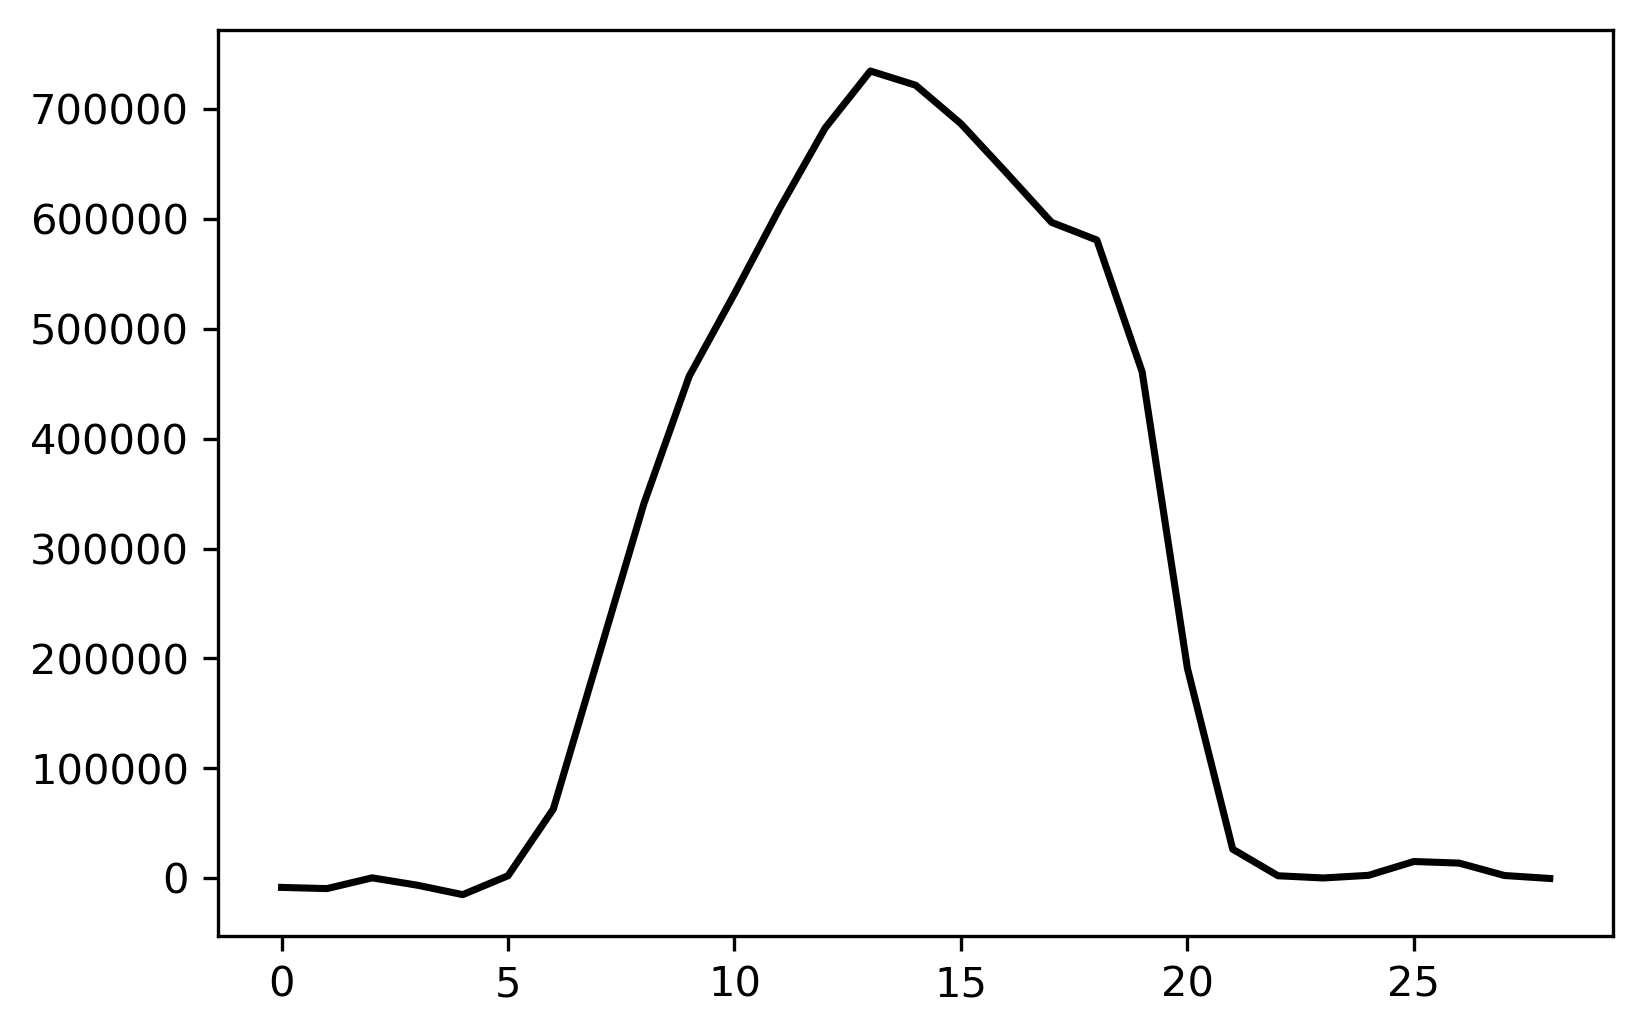

In [20]:
plt.figure(dpi=300)
plt.plot(obs.sum(axis=(1,2)), c='k', linewidth=1.7)

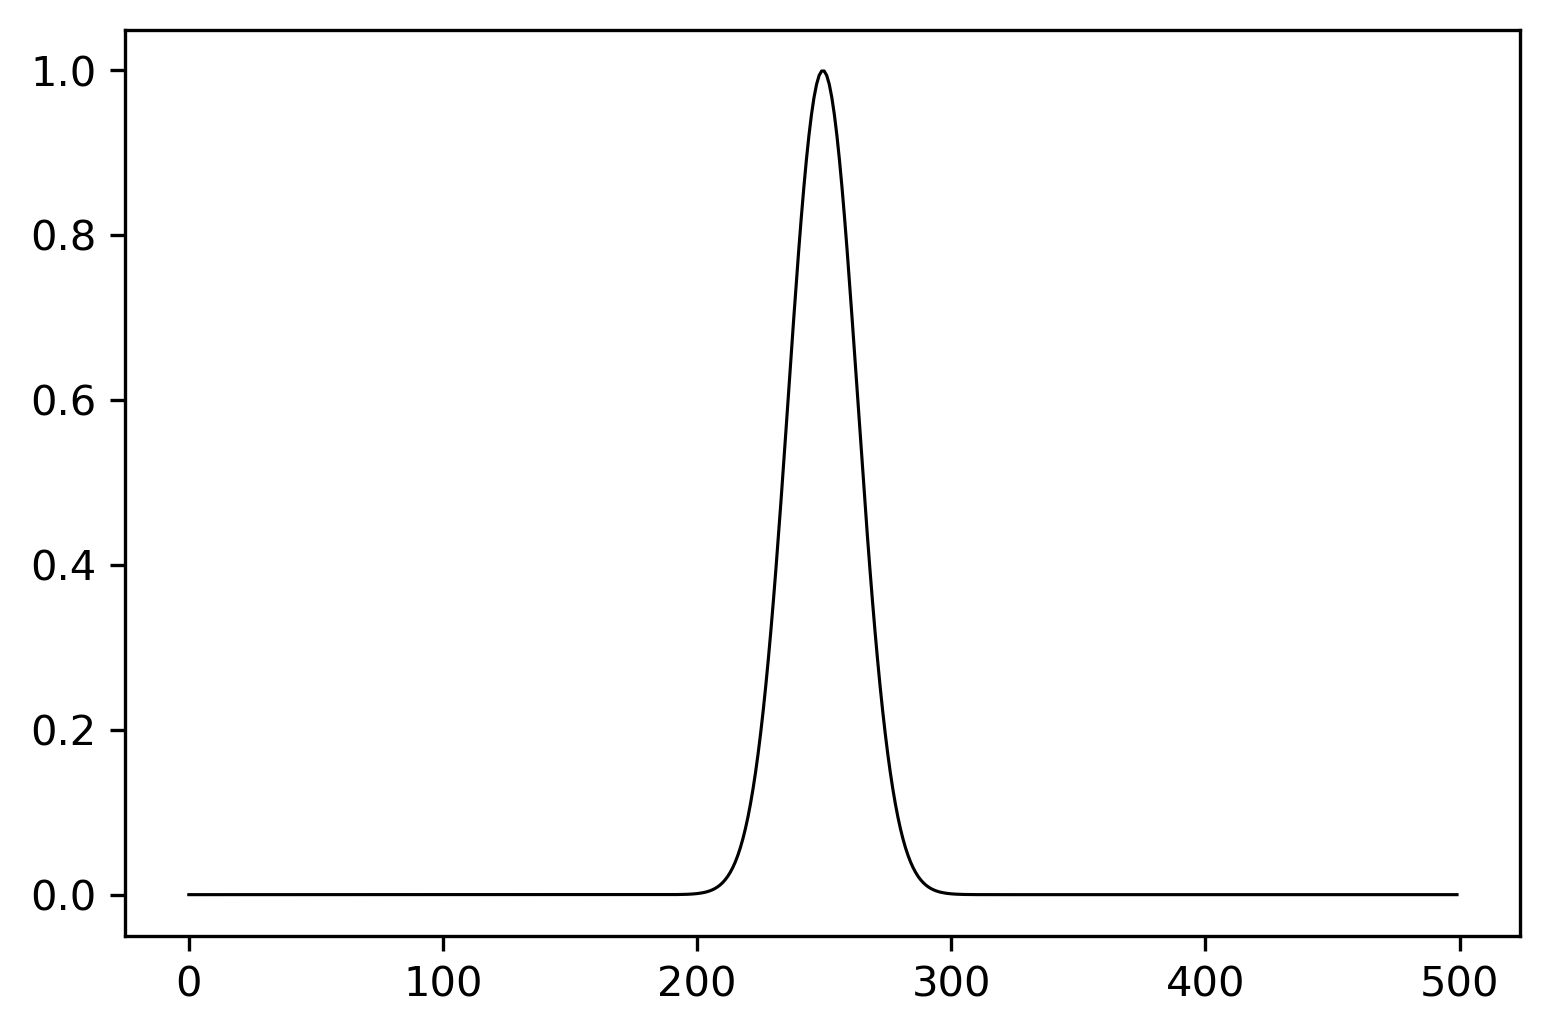

In [29]:
x = np.linspace(-13,13, 500)
y = np.exp(-x**2)

plt.figure(dpi=300)
plt.plot(y, c='k', linewidth=.75)

In [12]:
line = Line('CO', 1)

You have selected line:
    CO(J=2-1)
Please check the properties that were inferred:
    Frequency         2.305380000e+11  Hz
    Einstein A coeff  6.910000000e-07  1/s
    Molar mass        28.0101          g/mol


/home/frederikd/.local/lib/python3.9/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


In [13]:
velos = (1.0 - obs_freqs / (line.frequency * units.Hz)) * constants.c
velos = velos - np.mean(velos)
velos = velos.to('km/s').value
velos

array([-1.77791110e+01, -1.65091745e+01, -1.52392380e+01, -1.39693015e+01,
       -1.26993650e+01, -1.14294285e+01, -1.01594920e+01, -8.88955549e+00,
       -7.61961899e+00, -6.34968249e+00, -5.07974599e+00, -3.80980950e+00,
       -2.53987300e+00, -1.26993650e+00, -1.60725904e-11,  1.26993650e+00,
        2.53987300e+00,  3.80980950e+00,  5.07974599e+00,  6.34968249e+00,
        7.61961899e+00,  8.88955549e+00,  1.01594920e+01,  1.14294285e+01,
        1.26993650e+01,  1.39693015e+01,  1.52392380e+01,  1.65091745e+01,
        1.77791110e+01])

In [14]:
spatial_average = obs.sum(axis=(1,2))
line_centre     = obs_freqs[np.where(spatial_average==spatial_average.max())[0][0]]
line_centre

<Quantity 2.30502374e+11 Hz>

In [15]:
obs_freqs

<Quantity [2.30515069e+11, 2.30514092e+11, 2.30513116e+11, 2.30512139e+11,
           2.30511163e+11, 2.30510186e+11, 2.30509210e+11, 2.30508233e+11,
           2.30507256e+11, 2.30506280e+11, 2.30505303e+11, 2.30504327e+11,
           2.30503350e+11, 2.30502374e+11, 2.30501397e+11, 2.30500420e+11,
           2.30499444e+11, 2.30498467e+11, 2.30497491e+11, 2.30496514e+11,
           2.30495538e+11, 2.30494561e+11, 2.30493584e+11, 2.30492608e+11,
           2.30491631e+11, 2.30490655e+11, 2.30489678e+11, 2.30488702e+11,
           2.30487725e+11] Hz>

Text(0, 0.5, 'y [arc sec]')

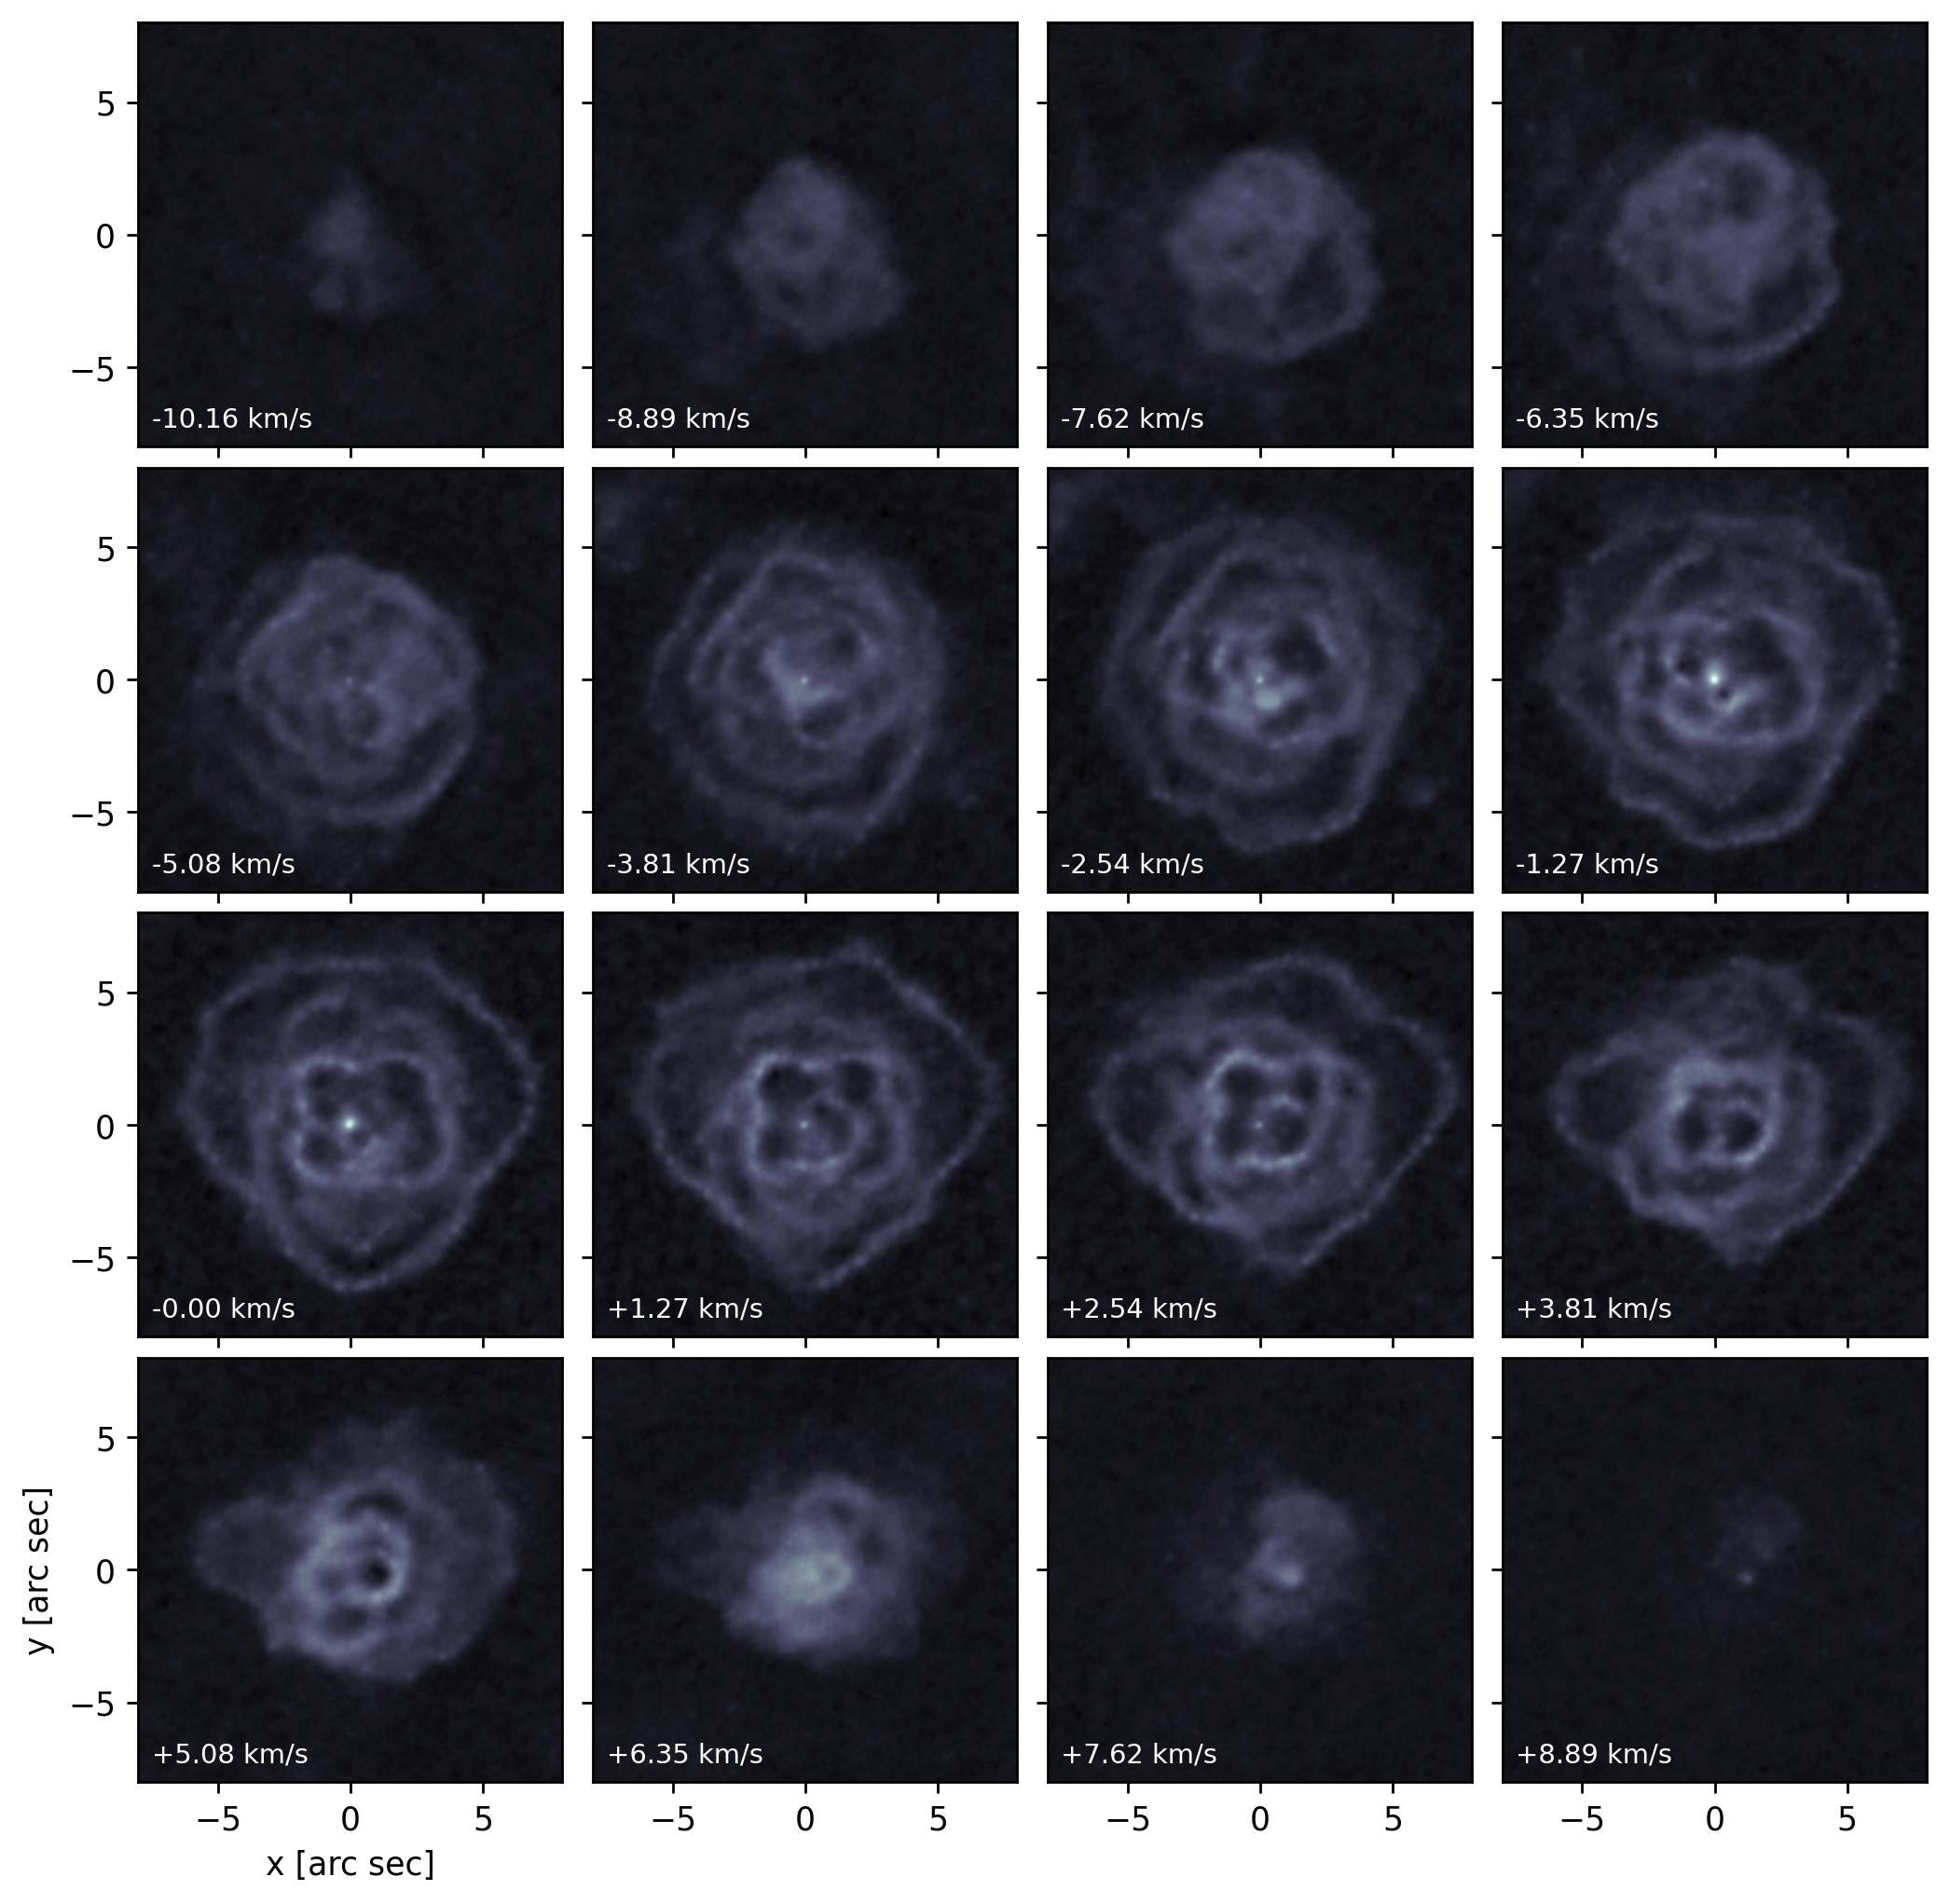

In [40]:
vmin = obs.min()
vmax = obs.max()

fig, axes = plt.subplots(
    nrows       =   4,
    ncols       =   4,
    dpi         = 250,
    sharex      = True,
    sharey      = True,
    figsize     = (10, 10),
    gridspec_kw = {'wspace':0.03, 'hspace':0.05}
)

for i, ax in enumerate(axes.ravel()):
    pcm = ax.imshow(obs[i+6], vmin=vmin, vmax=vmax, cmap='bone', extent=(xs_max, xs_min, ys_min, ys_max), origin='lower')
    ax.text(-7.5, -7.25, f'{velos[i+6]:+.2f} km/s', color='white', size='small')
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)

axes[3,0].set_xlabel('x [arc sec]')
axes[3,0].set_ylabel('y [arc sec]')

# fig.colorbar(pcm, ax=axes.ravel().tolist(), shrink=0.9)

In [28]:
axes

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

In [11]:
spatial_average = obs.sum(axis=(1,2))
line_centre     = obs_freqs[np.where(spatial_average==spatial_average.max())[0][0]]

In [12]:
line = Line('CO', 1)

You have selected line:
    CO(J=2-1)
Please check the properties that were inferred:
    Frequency         2.305380000e+11  Hz
    Einstein A coeff  6.910000000e-07  1/s
    Molar mass        28.0101          g/mol


/home/frederikd/.local/lib/python3.9/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


In [13]:
v_los = abs((1.0 - line_centre / (line.frequency * units.Hz)) * constants.c)
v_los

<Quantity 46328.79352163 m / s>

In [14]:
v_max = max(abs((1.0 - (obs_freqs / line_centre)) * constants.c.si)).value
v_max

19051.99170095877

In [15]:
o = obs.T
# fqs = freqs

def half_resolution(x):
    return 0.25*(x[0::2,0::2,:] + x[0::2,1::2,:] + x[1::2,0::2,:] + x[1::2,1::2,:])

# Create a list of hiearchically reduced observations
o_list = [o]
while o.shape[0]/2 >= 100:
    o = half_resolution(o)
    o_list.append(o)

for i, o in enumerate(o_list):
    print(f'o_list[{i}].shape =', list(o.shape))

o_list[0].shape = [3200, 3200, 29]
o_list[1].shape = [1600, 1600, 29]
o_list[2].shape = [800, 800, 29]
o_list[3].shape = [400, 400, 29]
o_list[4].shape = [200, 200, 29]
o_list[5].shape = [100, 100, 29]


In [16]:
obs = o

vmin = obs.min()
vmax = obs.max()

# Define a plot function
def plot(f):
    plt.figure(dpi=150)
    plt.imshow(obs[:,:,f], vmin=vmin, vmax=vmax)
            
interact(plot, f=(0, obs.shape[2]-1))

interactive(children=(IntSlider(value=14, description='f', max=28), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(f)>

In [17]:
obs = o_list[-1]

# Define a plot function
ymin = obs.min()
ymax = obs.max()

def plot(i,j):
    plt.figure(dpi=150)
    plt.step(obs_freqs, obs[i,j,:])
    plt.ylim((ymin, ymax))
    plt.axvline(line_centre.value, c='k')

# Return an interactive ipywidget
interact(
    plot,
    i=(0, obs.shape[0]-1),
    j=(0, obs.shape[1]-1)
)

interactive(children=(IntSlider(value=49, description='i', max=99), IntSlider(value=49, description='j', max=9…

<function __main__.plot(i, j)>

In [18]:
obs = torch.from_numpy(o_list[-1])
sizes = (s_x, s_y, s_z)
shape = (obs.shape[0], obs.shape[1], 100)
freqs = torch.from_numpy(obs_freqs.si.value)

In [19]:
model = TensorModel(
    sizes  = sizes,
    shape  = shape,
)

origin_ind    = np.array(shape)/2.0 - 0.5
r_x, r_y, r_z = model.get_radial_direction(origin=origin_ind)
r             = model.get_radius          (origin=origin_ind)

model['log_M'           ] = np.array([np.log(constants.M_sun.si.value)])
model['log_CO'          ] = np.log(1.0e+9) * np.ones(model.shape)
model['log_temperature' ] = np.log(5.0e+2) * np.ones(model.shape)
model['log_v_turbulence'] = np.log(1.5e+2) * np.ones(model.shape)
model['velocity_x'      ] = 1.0e+0 * r_x
model['velocity_y'      ] = 1.0e+0 * r_y
model['velocity_z'      ] = 1.0e+0 * r_z
model['log_v_los'       ] = np.array([np.log(v_los.si.value)])
# model['log_distance']

# loss = Loss(['reg', 'hyd_con', 'hyd_momx', 'hyd_momy', 'hyd_momz', 'hyd_eng'])
# loss = Loss(['rep', 'reg', 'hyd_con', 'hyd_momx', 'hyd_momy', 'hyd_momz', 'hyd_eng'])
loss = Loss(['rep', 'reg', 'sym', 'hyd_con', 'hyd_momx', 'hyd_momy', 'hyd_momz', 'hyd_eng'])

model.free_all()
model.fix('log_v_turbulence')
model.fix('log_v_los')

model.info()


Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_M                      Free          False    +6.976e+01     +6.976e+01     +6.976e+01
  log_CO                     Free          True     +2.072e+01     +2.072e+01     +2.072e+01
  log_temperature            Free          True     +6.215e+00     +6.215e+00     +6.215e+00
  log_v_turbulence           Fixed         True     +5.011e+00     +5.011e+00     +5.011e+00
  velocity_x                 Free          True     -9.999e-01     +0.000e+00     +9.999e-01
  velocity_y                 Free          True     -9.999e-01     +4.547e-18     +9.999e-01
  velocity_z                 Free          True     -9.999e-01     -3.979e-19     +9.999e-01
  log_v_los                  Fixed         False    +1.074e+01     +1.074e+01     +1.074e+01
sizes: (559518906748033.94, 559518906748033.94, 559518906748033.94)
shape: (100, 100, 100)


In [20]:
exclude = ['st']
key = 'st'

if len(key)!=0 and key not in exclude:
    print('yes')
else:
    print('no')

no


In [21]:
def get_doppler_shifted_frequencies(v_los, frequencies):
    """
    Doppler shifts frequencies given the velocity along the line of sight.
    """
    # Compute the Doppler shift for each cell
    shift = 1.0 + v_los * (1.0 / constants.c.si.value)

    # Create freqency tensor for each cell
    freqs = torch.einsum("..., f -> ...f", shift, frequencies)
    
    return freqs


def forward(model, freqs):
    """
    Forward model: image the given TensorModel at the given frequencies.
    """
    nCO    = torch.exp(model['log_CO'])         
    tmp    = torch.exp(model['log_temperature'])
    vel    =   v_max * model['velocity_z']
    v_turb = torch.exp(model['log_v_turbulence'])
    v_los  = torch.exp(model['log_v_los'])

    frequencies = get_doppler_shifted_frequencies(v_los-vel, freqs)
    
    # Compute the LTE line emissivity and opacity, and the line profile
    eta, chi = line.LTE_emissivity_and_opacity(nCO, tmp, v_turb, frequencies)
    
    # Create an image of the line
    img = model.create_image(eta, chi, axis=2)
    
    return img

In [22]:
gamma = 1.2
mu    = 2.381 * constants.u.si.value

def steady_state_hydrodynamic_loss(model, f_x=0.0, f_y=0.0, f_z=0.0, heating_m_cooling=0.0):
    """
    Loss assuming steady state hydrodynamics, i.e. vanishing time derivatives.
    """

    r = model.get_coords(origin=origin_ind)
    d = torch.from_numpy(r / np.linalg.norm(r, axis=0)**3)
    
    log_rho = model['log_CO']
    log_tmp = model['log_temperature'] 
    log_M   = model['log_M']

    rho = torch.exp(log_rho)         
    tmp = torch.exp(log_tmp)
    M   = torch.exp(log_M)
    
    v_x = v_max * model['velocity_x']
    v_y = v_max * model['velocity_y']
    v_z = v_max * model['velocity_z']

    kBT_o_mu = (constants.k_B.si.value / mu) * tmp

    # Energy    
    eng = 0.5 * (v_x**2 + v_y**2 + v_z**2) + (gamma / (gamma - 1.0)) * kBT_o_mu

    # log rho + log T
    log_rho_p_log_tmp = log_rho + log_tmp
    
    f_x = -constants.G.si.value * M * d[0]
    f_y = -constants.G.si.value * M * d[1]
    f_x = -constants.G.si.value * M * d[2]

    # Continuity equation (steady state): div(ρ v) = 0
    loss_cont = model.diff_x(rho * v_x) + model.diff_y(rho * v_y) + model.diff_z(rho * v_z)

    # Momentum equation (steady state): v . grad(v) + grad(P) / rho = f
    loss_momx = v_x * model.diff_x(v_x) + v_y * model.diff_y(v_x) + v_z * model.diff_z(v_x) + kBT_o_mu * model.diff_x(log_rho_p_log_tmp) - f_x
    loss_momy = v_x * model.diff_x(v_y) + v_y * model.diff_y(v_y) + v_z * model.diff_z(v_y) + kBT_o_mu * model.diff_y(log_rho_p_log_tmp) - f_y
    loss_momz = v_x * model.diff_x(v_z) + v_y * model.diff_y(v_z) + v_z * model.diff_z(v_z) + kBT_o_mu * model.diff_z(log_rho_p_log_tmp) - f_z

    # Energy equation (steady state): div(u v) = 0
    loss_engy = rho * (model.diff_x(eng) * v_x + model.diff_y(eng) * v_y + model.diff_z(eng) * v_z) - heating_m_cooling

    # Compute the mean squared losses
    losses = torch.stack([
        ((loss_cont/     rho )**2).mean(),
        ((loss_momx/     v_x )**2).mean(),
        ((loss_momy/     v_y )**2).mean(),
        ((loss_momz/     v_z )**2).mean(),
        ((loss_engy/(rho*eng))**2).mean()
    ])

    # Return losses
    return losses


def diff_loss(arr):
    loss = torch.zeros(1)
    for d in range(arr.dim()):
        loss += torch.mean(torch.diff(arr, dim=d)**2)
    return loss


def z_pos_symmetry_loss(arr):
    return torch.mean((arr - torch.flip(arr, dims=(2,)))**2)


def z_neg_symmetry_loss(arr):
    return torch.mean((arr + torch.flip(arr, dims=(2,)))**2)

In [23]:
class SphericalLoss:
    """
    Copmutes the deviation from spherical symmetry. 
    """

    def __init__(self, model, origin, weights=None):
        # Get radial coordinates w.r.t. the given origin.
        r = model.get_radius(origin=origin)
        # Define the number of radial bins.
        self.N = int(np.mean(model.shape)//2)
        # Define the boundaries of the radial bins.
        r_min = r.min()
        r_max = r.max()
        # Extract the indices of the radial bins.
        self.r_ind = ((r - r_min) *  ((self.N - 1) / (r_max - r_min))).astype(np.int64)
        # Extract the spherical masks (which mask everything but radial bin 'i').
        self.masks = [self.r_ind==i for i in range(self.N)]
        # Set the weights, if necessary.
        if weights is None:
            self.weights = torch.ones(self.N)
        else:
            self.weights = weights


    def eval(self, var):
        # Compute the standard deviation of the variable data in each radial bin.
        sph_std = torch.zeros(self.N)
        for i in range(self.N):
            sph_std[i] = var[self.masks[i]].std()
        return torch.mean(self.weights * sph_std)

In [27]:
spherical_loss = SphericalLoss(model, origin_ind)    

In [28]:
w_rep = 1.0 / nn.functional.mse_loss(forward(model,freqs), obs).item()
w_reg = 1.0 / model.apply_to_fields(diff_loss).item()

L_con, L_mom_x, L_mom_y, L_mom_z, L_eng = steady_state_hydrodynamic_loss(model)

w_con = 1.0 / L_con.item()
w_mom = 1.0 / torch.stack([L_mom_x, L_mom_y, L_mom_z]).mean().item()
w_eng = 1.0 / L_eng.item()

In [29]:
img = forward(model,freqs)

def plot_spectrum():
    """
    Plot spectrum at a pixel for this observation.
    """
    # Define a plot function
    def plot(i,j):
        plt.figure(dpi=150)
        plt.plot(freqs.numpy(), obs[i,j,:].data)
        plt.plot(freqs.numpy(), img[i,j,:].data * 1.0e+14)
        # plt.ylim((1.0e-30, 1.0e+1))
        # plt.yscale('log')
        # plt.axvline(line.frequency, c='k')

    # Return an interactive ipywidget
    return interact(plot,
                    i=(0, obs.shape[0]-1),
                    j=(0, obs.shape[1]-1) )

plot_spectrum()

interactive(children=(IntSlider(value=49, description='i', max=99), IntSlider(value=49, description='j', max=9…

<function __main__.plot_spectrum.<locals>.plot(i, j)>

In [30]:
def fit(loss, model, obs, N_epochs=10, lr=1.0e-1, w_rep=1.0, w_reg=1.0, w_sym=1.0, w_con=1.0, w_mom=1.0, w_eng=1.0):

    optimizer = Adam(model.free_parameters(), lr=lr)

    for _ in tqdm(range(N_epochs)):
        
        # Run forward model
        img = forward(model, freqs)
 
        # Compute the reproduction loss
        loss['rep'] = w_rep * nn.functional.mse_loss(img*1.0e+14, obs)

        # Symmetry loss
        # loss['sym'] = w_sym * (torch.zeros(1)                \
        #     + z_pos_symmetry_loss(model['log_CO'          ]) \
        #     + z_pos_symmetry_loss(model['log_temperature' ]) \
        #     + z_pos_symmetry_loss(model['log_v_turbulence']) \
        #     + z_pos_symmetry_loss(model['velocity_x'      ]) \
        #     + z_pos_symmetry_loss(model['velocity_y'      ]) \
        #     + z_neg_symmetry_loss(model['velocity_z'      ]) )

        # Compute the regularisation loss
        loss['reg'] = w_reg * model.apply_to_fields(diff_loss)
        loss['sym'] = w_sym * model.apply_to_fields(
            func    = spherical_loss.eval,
            exclude = ['velocity_x', 'velocity_y', 'velocity_z'],
            include = [model['velocity_x']**2 + model['velocity_y']**2 + model['velocity_z']**2]
        )

        L_con, L_mom_x, L_mom_y, L_mom_z, L_eng = steady_state_hydrodynamic_loss(model)
    
        loss['hyd_con' ] = w_con * L_con
        loss['hyd_momx'] = w_mom * L_mom_x
        loss['hyd_momy'] = w_mom * L_mom_y
        loss['hyd_momz'] = w_mom * L_mom_z
        loss['hyd_eng' ] = w_eng * L_eng

        # Set gradients to zero
        optimizer.zero_grad()
        # Backpropagate gradients
        loss.tot().backward()
        # Update parameters
        optimizer.step()

  0%|          | 0/5 [00:00<?, ?it/s]/home/frederikd/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 5/5 [00:12<00:00,  2.46s/it]


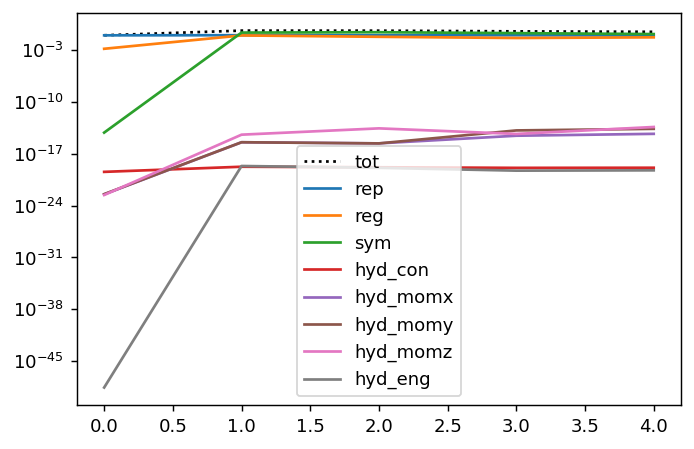

In [31]:
fit(loss, model, obs, N_epochs = 5, lr = 1.0e-1)
loss.plot()

In [32]:
w_rep = 1.0 /  loss['rep'     ].item()
w_reg = 1.0 /  loss['reg'     ].item()
w_sym = 1.0 /  loss['sym'     ].item()
w_con = 1.0 /  loss['hyd_con' ].item()
w_mom = 3.0 / (loss['hyd_momx'] + loss['hyd_momy'] + loss['hyd_momz']).item()
w_eng = 1.0 /  loss['hyd_eng' ].item()

In [33]:
loss.__init__(keys=loss.loss.keys())

100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


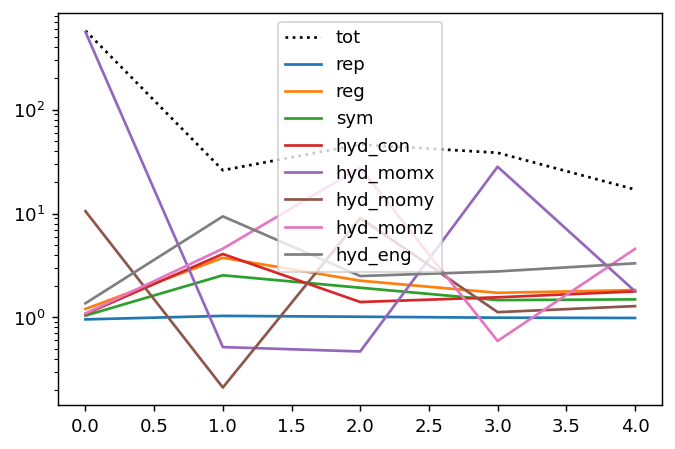

In [34]:
fit(loss, model, obs,
    N_epochs = 5,
    lr       = 1.0e-1,
    w_rep    = w_rep,
    w_reg    = w_reg,
    w_sym    = w_sym,
    w_con    = w_con,
    w_mom    = w_mom,
    w_eng    = w_eng
)

loss.plot()

In [35]:
w_rep *= 1.0 /  loss['rep'     ].item()
w_reg *= 1.0 /  loss['reg'     ].item()
w_sym *= 1.0 /  loss['sym'     ].item()
w_con *= 1.0 /  loss['hyd_con' ].item()
w_mom *= 3.0 / (loss['hyd_momx'] + loss['hyd_momy'] + loss['hyd_momz']).item()
w_eng *= 1.0 /  loss['hyd_eng' ].item()

In [36]:
loss.__init__(keys=loss.loss.keys())

In [48]:
fit(loss, model, obs,
    N_epochs = 250,
    lr       = 2.0e-2,
    w_rep    = 1.0e+4*w_rep,
    w_reg    = w_reg,
    w_sym    = 1.0e-2*w_sym,
    w_con    = w_con,
    w_mom    = w_mom,
    w_eng    = w_eng
)

loss.plot()

 46%|████▋     | 116/250 [04:34<05:15,  2.36s/it]

In [47]:
np.sqrt(3)/2*np.pi

2.7206990463513265

In [213]:
loss.__init__(keys=loss.loss.keys())

In [214]:
fit(loss, model, obs,
    N_epochs = 250,
    lr       = 2.0e-2,
    w_rep    = w_rep,
    w_reg    = w_reg,
    w_con    = w_con,
    w_mom    = w_mom,
    w_eng    = w_eng
)

loss.plot()

  9%|▉         | 22/250 [00:47<08:03,  2.12s/it]

In [38]:
img = forward(model, freqs)

velos = (freqs / line.frequency - 1.0) * constants.c.si.value

def plot(i,j):
    plt.figure(dpi=150)
    plt.title('Observations')
    plt.plot(velos, 1.0e+14*img[i,j,:].data, label='img')
    plt.plot(velos, obs[i,j,:].data, label='obs')
    # plt.ylim((1.0e-30, 1.0e+1))
    # plt.yscale('log')
    # plt.axvline(line.frequency, c='k')
    plt.legend()

interact(plot, 
    i=(0, img.shape[0]-1),
    j=(0, img.shape[1]-1)
)


interactive(children=(IntSlider(value=49, description='i', max=99), IntSlider(value=49, description='j', max=9…

<function __main__.plot(i, j)>

In [46]:
plot_cube_2D(model['log_CO'])

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function p3droslo.plot.plot_cube_2D.<locals>.plot(z)>

In [40]:
plot_cube_2D(torch.exp(model['log_temperature']).T)

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function p3droslo.plot.plot_cube_2D.<locals>.plot(z)>

In [41]:
# dat = torch.exp(model['log_v_los']) - model['velocity_z']
dat =  model['velocity_z']

def plot(i,j):
    plt.figure(dpi=150)
    plt.title('velocity')
    plt.plot(dat[i,j,:].data)
    # plt.ylim((1.0e-30, 1.0e+1))
    # plt.yscale('log')
    # plt.axvline(line.frequency, c='k')
    # plt.legend()

interact(plot, 
    i=(0, dat.shape[0]-1),
    j=(0, dat.shape[1]-1)
)

interactive(children=(IntSlider(value=49, description='i', max=99), IntSlider(value=49, description='j', max=9…

<function __main__.plot(i, j)>

In [42]:
plot_cube_2D(torch.abs(torch.exp(model['log_v_los']-model['velocity_z'].T)))

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function p3droslo.plot.plot_cube_2D.<locals>.plot(z)>

In [43]:
img = forward(model, freqs)

velos = (freqs / line.frequency - 1.0) * constants.c.si.value

def plot(i,j):
    plt.figure(dpi=150)
    plt.title('Observations')
    plt.plot(velos, 1.0e+14*img[i,j,:].data, label='img')
    plt.plot(velos,         obs[i,j,:].data, label='obs')
    # plt.ylim((1.0e-30, 1.0e+1))
    # plt.yscale('log')
    # plt.axvline(line.frequency, c='k')
    plt.legend()

interact(plot, 
    i=(0, img.shape[0]-1),
    j=(0, img.shape[1]-1)
)


interactive(children=(IntSlider(value=49, description='i', max=99), IntSlider(value=49, description='j', max=9…

<function __main__.plot(i, j)>

In [44]:
plot_cube_2D(img)

interactive(children=(IntSlider(value=14, description='z', max=28), Output()), _dom_classes=('widget-interact'…

<function p3droslo.plot.plot_cube_2D.<locals>.plot(z)>

In [59]:
model.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_M                      Free          False    +6.973e+01     +6.973e+01     +6.973e+01
  log_CO                     Free          True     +1.882e+01     +2.005e+01     +2.773e+01
  log_temperature            Free          True     +4.480e+00     +7.104e+00     +9.446e+00
  log_v_turbulence           Free          True     +4.428e+00     +4.922e+00     +7.957e+00
  velocity_x                 Free          True     -1.185e+00     +9.266e-04     +1.061e+00
  velocity_y                 Free          True     -1.206e+00     +2.678e-03     +1.270e+00
  velocity_z                 Free          True     -1.632e+00     +1.546e-02     +1.030e+00
  log_v_los                  Free          False    +1.036e+01     +1.036e+01     +1.036e+01
sizes: (559518906748033.94, 559518906748033.94, 559518906748033.94)
shape: (100, 100, 100)
